In [1]:
import cv2
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten, MaxPool2D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
import cv2

# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)

    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
    
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [3]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img = cv2.resize(image, (333, 75))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img_binary = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)   
    img_erode = cv2.erode(img_binary, (3,3))
    img_dilate = cv2.dilate(img_erode, (3,3))
    
    #license_plate = cv2.resize(plate, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    #license_plate = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    #license_plate = cv2.GaussianBlur(license_plate, (5, 5), 0)

    LP_WIDTH = img_dilate.shape[0]
    LP_HEIGHT = img_dilate.shape[1]

    # Make borders white
    img_dilate[0:3,:] = 255
    img_dilate[:,0:3] = 255
    img_dilate[72:75,:] = 255
    img_dilate[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6, LP_WIDTH/2, LP_HEIGHT/10, 2*LP_HEIGHT/3]

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_dilate)

    return char_list

In [4]:
img = cv2.imread('car_plate.png')
char = segment_characters(img)

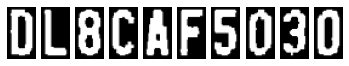

In [5]:
import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.05, height_shift_range=0.05)

train_generator = train_datagen.flow_from_directory(
        './desktop/data/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        './desktop/data/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers

In [8]:
model = Sequential()
model.add(Conv2D(32, (24,24), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

C:\Users\Viswanath Bodapati\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
import tensorflow as tf
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc') > 0.992):
      self.model.stop_training = True

In [10]:
import datetime
!rm -rf logs
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


'rm' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
batch_size = 1
callbacks = [tensorboard_callback, stop_training_callback()]
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples // batch_size,
      epochs = 23)

Epoch 1/23


C:\Users\Viswanath Bodapati\AppData\Local\Temp\ipykernel_13932\1272897833.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


864/864 [==============================] - 12s 13ms/step - loss: 3.4424 - accuracy: 0.0856 - val_loss: 3.1647 - val_accuracy: 0.3657
Epoch 2/23
864/864 [==============================] - 12s 13ms/step - loss: 2.8047 - accuracy: 0.3356 - val_loss: 2.3440 - val_accuracy: 0.6296
Epoch 3/23
864/864 [==============================] - 11s 13ms/step - loss: 2.0415 - accuracy: 0.5486 - val_loss: 1.6006 - val_accuracy: 0.8148
Epoch 4/23
864/864 [==============================] - 12s 14ms/step - loss: 1.3693 - accuracy: 0.6991 - val_loss: 1.1051 - val_accuracy: 0.8472
Epoch 5/23
864/864 [==============================] - 12s 13ms/step - loss: 0.9822 - accuracy: 0.7824 - val_loss: 0.8468 - val_accuracy: 0.8843
Epoch 6/23
864/864 [==============================] - 11s 13ms/step - loss: 0.7693 - accuracy: 0.8287 - val_loss: 0.6346 - val_accuracy: 0.8750
Epoch 7/23
864/864 [==============================] - 12s 14ms/step - loss: 0.6376 - accuracy: 0.8368 - val_loss: 0.5302 - val_accuracy: 0.9028
Epo

In [12]:
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = model.predict(img)[0]
        y_ = np.argmax(y_)#predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

#print(show_results())

In [ ]:
'''
  filename = "license_plates.txt"
  temp = show_results()
  with open(filename, "a") as f:
    f.write(temp)
  
  for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
   
  #print(show_results())
'''

In [13]:
def extract_plate(img): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    global plate
    
    #Loads the data required for detecting the license plates from cascade classifier.
    plate_cascade = cv2.CascadeClassifier('./indian_license_plate.xml')

    # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.3, minNeighbors = 7)

    for (x,y,w,h) in plate_rect:
        a,b = (int(0.02*img.shape[0]), int(0.025*img.shape[1])) #parameter tuning
        plate = plate_img[y+a:y+h-a, x+b:x+w-b,:]
        # finally representing the detected contours by drawing rectangles around the edges.
        cv2.rectangle(plate_img, (x,y), (x+w, y+h), (51,51,255), 3)
        
        
    return plate_img, plate # returning the processed image

In [32]:
cap = cv2.VideoCapture('car_video.mp4')

while True:
  ret, frames = cap.read()
  
  if frames is None:
    break
  x,y = extract_plate(frames)
  #cv2.imshow('ret',y)
  #cv2.waitKey(0)
  #cv2.destroyAllWindows() 
  
  char = segment_characters(y)
  filename = "license_plates.txt"
  with open(filename, 'a') as file:
    file.write(show_results())
  with open(filename,'a') as file:
    file.write('\n')
  print("Number detected")

1/1 [==============================] - 0s 43ms/step
Number detected
1/1 [==============================] - 0s 40ms/step
Number detected
1/1 [==============================] - 0s 39ms/step
Number detected
1/1 [==============================] - 0s 40ms/step
Number detected
1/1 [==============================] - 0s 30ms/step
Number detected
1/1 [==============================] - 0s 26ms/step
Number detected
1/1 [==============================] - 0s 25ms/step
Number detected
1/1 [==============================] - 0s 39ms/step
Number detected
1/1 [==============================] - 0s 36ms/step
Number detected
1/1 [==============================] - 0s 29ms/step
Number detected
1/1 [==============================] - 0s 31ms/step
Number detected
1/1 [==============================] - 0s 31ms/step
Number detected
1/1 [==============================] - 0s 44ms/step


KeyboardInterrupt: 

In [30]:
cap = cv2.VideoCapture('car_video.mp4')

while True:
  ret, frames = cap.read()
  
  if frames is None:
    break
  x,y = extract_plate(frames)
  #cv2.imshow('ret',y)
  #cv2.waitKey(0)
  #cv2.destroyAllWindows() 
  
  char = segment_characters(y)
  filename = "license_plates.txt"
  with open(filename, 'r') as file:
    content = file.read()
    if show_results() in content:
        print('Vehicle can pass')
    else:
        print('Vehicle cannot pass')  
        
        

1/1 [==============================] - 0s 50ms/step
Vehicle can pass
1/1 [==============================] - 0s 47ms/step
Vehicle can pass
1/1 [==============================] - 0s 46ms/step
Vehicle can pass
1/1 [==============================] - 0s 51ms/step
Vehicle can pass
1/1 [==============================] - 0s 37ms/step


KeyboardInterrupt: 

In [31]:
filename = "license_plates.txt"
with open(filename, 'r') as file:
  content = file.read()
  if "AP08EF0680" in content:
      print('Vehicle can pass')
  else:
      print('Vehicle cannot pass')  

Vehicle cannot pass


In [ ]:
'''model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=36, activation='softmax'))'''

In [ ]:
'''# !kill 8400
%load_ext tensorboard
%tensorboard --logdir logs/fit'''

In [ ]:
#model.compile()